In [1]:
import implicit
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.sparse import coo_matrix
from implicit.nearest_neighbours import bm25_weight, tfidf_weight
from importlib import reload
import kaggle_hm.als_model
from kaggle_hm.chart_model import compute_chart
from kaggle_hm.evaluation import compute_precision, enrich_data, precision_by_age, plot_precision_at_k_segments, plot_precision_at_k, precision_by_usage
from kaggle_hm.utils import visualize_items
from kaggle_hm.config import data_root, train_dates, test_dates
from kaggle_hm.chart_model import filter_data

In [11]:
reload(kaggle_hm.als_model)

<module 'kaggle_hm.als_model' from '/home/sstamenov/kaggle-hm/kaggle_hm/als_model.py'>

In [2]:
df = pd.read_parquet(data_root / 'clean' / 'transactions.parquet')
c = pd.read_parquet(data_root / 'clean' / 'customers.parquet').set_index('customer_id')
c['age_group'] = pd.cut(c['age'], bins=[16, 21, 25, 30, 40, 50, 60, 100])

In [3]:
cols = [f'rel_{i + 1}' for i in range(12)]
full_ds = filter_data(df, to_date='2020-09-08')
test = filter_data(df, test_dates['start'], test_dates['end'])
train = filter_data(df, '2020-08-24', '2020-09-08')

results = test.groupby('customer_id', observed=True).agg(bought=('article_id', set)).reset_index()

In [4]:
top12 = compute_chart(train)

pipeline = kaggle_hm.als_model.MatrixFactorizationPipeline(min_items=1, min_customers=1, cell_value='tfidf', factors=256, iterations=5, regularization=0.01)
pipeline.fit(train)
rec_df = pipeline.predict(full_ds)

# ensemble results
comb = results.merge(rec_df, on='customer_id', how='left')
comb['naive_pred'] = [top12 for _ in range(comb.shape[0])]
comb['prediction'] = comb['candidates'].combine_first(comb['naive_pred'])
comb = compute_precision(comb)

#items 24780
#customers 157433


  0%|          | 0/5 [00:00<?, ?it/s]

In [9]:
cond = ~comb['customer_id'].isin(full_ds['customer_id'].unique())
comb.loc[cond, 'segment'] = 'cold'

cond = comb['customer_id'].isin(full_ds['customer_id'].unique())
comb.loc[cond, 'segment'] = 'old'

cond = comb['customer_id'].isin(train['customer_id'].unique())
comb.loc[cond, 'segment'] = 'train'

In [5]:
comb = enrich_data(full_ds, comb.set_index('customer_id'), c)

In [10]:
comb['segment'].value_counts()

old      42331
train    24293
cold      5395
Name: segment, dtype: int64

In [13]:
comb.groupby('segment').agg(avg_p=('precision', 'mean'))

,avg_p
segment,
cold,0.006586
old,0.014842
train,0.042779


In [12]:
comb['precision'].mean()

0.023647379537977548

In [14]:
N = 1000
precisions = np.zeros(N)
for i in range(N):
    precisions[i] = comb.sample(n=1000)['precision'].mean()

In [15]:
pd.Series(precisions).describe()

count    1000.000000
mean        0.023535
std         0.003558
min         0.013153
25%         0.021072
50%         0.023422
75%         0.025862
max         0.037035
dtype: float64

<AxesSubplot:ylabel='Count'>

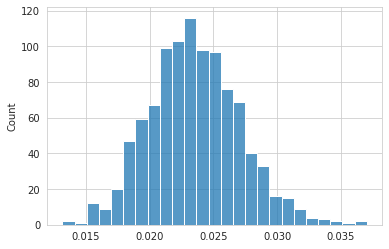

In [16]:
sns.histplot(precisions)

In [17]:
comb[~comb['candidates'].isna()]['precision'].mean()

0.025286197957060524

# todo

In [ ]:
trends = train.groupby('article_id', observed=True).agg(min_dt=('t_dat', 'min'), max_dt=('t_dat', 'max'))

In [ ]:
trends.shape

In [ ]:
trends['min_dt'].dt.to_period('m').value_counts().sort_index().plot.bar()

In [ ]:
trends['max_dt'].dt.to_period('m').value_counts().sort_index().plot.bar()

In [ ]:
train.merge(trends, left_on='article_id', right_index=True, how='left')['min_dt'].dt.to_period('m').value_counts().sort_index().plot.bar()

In [ ]:
_ = results['prediction'].explode().reset_index().merge(trends, left_on='prediction', right_index=True, how='left')
(_['min_dt'].dt.to_period('m').value_counts().sort_index()).plot.bar()

In [ ]:
train_dates

In [ ]:
_ = test.merge(trends, left_on='article_id', right_index=True, how='left')
(_['min_dt'].dt.to_period('m').value_counts().sort_index() / _.shape[0]).plot.bar()

In [ ]:
top_aug = test.merge(trends[trends['min_dt'].dt.to_period('m') == '2020-08'], left_on='article_id', right_index=True)['article_id'].value_counts()[:64]

In [ ]:
test.merge(trends[trends['min_dt'].dt.to_period('m') == '2020-08'], left_on='article_id', right_index=True)

In [ ]:
visualize_items(top_aug.index)

In [ ]:
test.groupby('article_id')['customer_id'].count().reset_index().merge(trends, left_on='article_id', right_index=True, how='left')['min_dt'].dt.to_period('m').value_counts().sort_index().plot.bar()

In [ ]:
results_ext = enrich_data(train, results, c)

In [ ]:
results_ext.shape

# Submission

In [ ]:
submission = pd.read_csv('/data/sstamenov/kaggle-data/sample_submission.csv').drop(columns=['prediction'])

In [ ]:
submission.head()

In [ ]:
full_ds = filter_data(df, to_date='2020-09-22')
train = filter_data(df, '2020-09-15', '2020-09-22')

In [ ]:
pipeline = kaggle_hm.als_model.MatrixFactorizationPipeline(min_items=1, min_customers=1, cell_value='tfidf', factors=256, iterations=5, regularization=0.01)
pipeline.fit(train)
pipeline.predict(full_ds)

In [ ]:
submission = submission.merge(rec_df, on='customer_id', how='left')

In [ ]:
top12 = compute_chart(train)
submission['naive_pred'] = ' '.join(top12)
submission['prediction'] = submission['candidates'].combine_first(submission['naive_pred'])

In [ ]:
submission.head()

In [ ]:
submission.shape[0]

In [ ]:
submission[['customer_id', 'prediction']].to_csv('/data/sstamenov/kaggle-data/output/implicit_submission.csv', index=False)